In [6]:
import sys
sys.version 

'3.10.14 | packaged by Anaconda, Inc. | (main, May  6 2024, 19:44:50) [MSC v.1916 64 bit (AMD64)]'

In [7]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [5]:
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
# logging.langsmith("algorithm_education_agent")

# logging.langsmith("code_review_agent", set_enable=False)

LangSmith 추적을 시작합니다.
[프로젝트명]
algorithm_education_agent


In [8]:
import os
import re
from langchain_community.chat_models.openai import ChatOpenAI

gpt3 = ChatOpenAI(model_name="gpt-3.5-turbo")

In [22]:
import operator
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain.schema import StrOutputParser
from langchain_core.messages import BaseMessage
from langchain.prompts import ChatPromptTemplate
from typing import Type, Callable, Dict, Any, TypedDict, Annotated, Optional, List

# 모델과 구조화된 출력 체인을 생성하는 함수
def create_structured_output_chain(
    system_template: str, 
    human_template: str,
    model: str,
    struct: Type[BaseModel],
    partial_variables: Dict[str, Any] = {}
) -> Callable:
    # 시스템 및 사용자 템플릿 생성
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_template), 
        ("human", human_template)
    ]).partial(**partial_variables)

    # 모델 선택을 위한 딕셔너리
    model_mapping = {
        "gpt4_0": ChatOpenAI(model="gpt-4o", temperature=0),
        "gpt3_0": ChatOpenAI(model="gpt-3.5-turbo", temperature=0),
        "gpt4": ChatOpenAI(model="gpt-4o"),
        "default": ChatOpenAI(model="gpt-3.5-turbo")
    }

    # model 값에 따라 해당 모델 선택, 기본값은 "gpt-3.5-turbo"
    model_instance = model_mapping.get(model, model_mapping["default"])
        
    # 모델과 구조화된 출력 연결
    return prompt | model_instance.with_structured_output(struct)

In [23]:
from langchain_core.documents import Document  # Document 객체가 정의된 모듈에서 가져와야 함

# AlgorithmState 정의
class AlgorithmState(TypedDict):
    user_input: str
    output: str
    Wikipedia_search_query: str
    Wikipedia_Document: list[Document]
    Generated_answer: str

In [24]:
# Wikipedia 쿼리 출력을 위한 데이터
class WikipediaQueryOutput(BaseModel):
    Wikipedia_search_query: str = Field(description="The generated simple Wikipedia query based on the user's input.")

# Step 1: 사용자 입력으로부터 검색 쿼리 생성
def generate_wikipedia_query(state: AlgorithmState):
    system_template = """
    You are an expert in algorithms and data structures.
    Based on the user's input, generate a simple query to search for the key concept on Wikipedia.
    Create the query to capture the essence of the user's question in simple keywords.
    """
    
     # 사용자 입력과 템플릿을 기반으로 검색 쿼리 생성
    chain = create_structured_output_chain(
        system_template=system_template,
        human_template="{user_input}",
        model="default",
        struct=WikipediaQueryOutput,
        partial_variables={"user_input": state["user_input"]}
    )
    return chain.invoke(state)

In [25]:
from langchain.document_loaders import WikipediaLoader

# Step 2: Wikipedia에서 쿼리로 문서 검색
def search_wikipedia(state: AlgorithmState) -> AlgorithmState:
    query = state["Wikipedia_search_query"]  # 검색 쿼리 가져오기
    
    # WikipediaLoader로 문서 검색 (최대 2개)
    loader = WikipediaLoader(query=query, load_max_docs=2)
    documents = loader.load()
    
    state["Wikipedia_Document"] = documents

    return state

In [26]:
# LaTeX 이스케이프 처리 함수
def escape_latex(text):
    # LaTeX 수식을 찾아 이스케이프 처리 (줄바꿈 포함)
    def replace_latex(match):
        return '{{' + match.group(1) + '}}' + match.group(2)
    
    # {\\displaystyle ...}\n 패턴을 찾아 이스케이프 처리
    escaped = re.sub(r'(\{\\displaystyle [^}]+\})(\n?)', replace_latex, text)
    
    # 남은 중괄호들을 이스케이프 처리
    escaped = escaped.replace("{", "{{").replace("}", "}}")
    
    return escaped

In [34]:
from langchain.schema import StrOutputParser

# Step 3: 검색된 결과를 바탕으로 답변 생성
def generate_answer(state: AlgorithmState) -> AlgorithmState:
    system_template = """
    Based on the Wikipedia content provided below, answer the user's question in a detailed and easy-to-understand way.
    
    Wikipedia content: {document_content}
    
    The user asked: {user_input}
    
    Provide a thorough and easy-to-follow explanation, ensuring the response is detailed and simplified for clear understanding using the Wikipedia data. 
    Additionally, use examples to make the explanation clearer and more relatable.
    """
    
    # state에서 Wikipedia_Document 가져오기
    documents = state["Wikipedia_Document"]
    
    # 문서의 내용을 모두 합쳐 하나의 문자열로 만들기
    document_content = " ".join([escape_latex(doc.page_content) for doc in documents])


     # 분석 수행
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_template), 
        ("human", "{user_input}\n{document_content}")
    ])
    chain = prompt | gpt3 | StrOutputParser()
    result = chain.invoke({"user_input": state["user_input"], "document_content": document_content})

    state["output"] = result
    
    # 업데이트된 state 반환
    return state

# Algorithm Education Graph

In [35]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 알고리즘 및 자료구조 교육 워크플로우 생성
Algorithm_workflow = StateGraph(AlgorithmState)

In [36]:
from langgraph.graph import START, END, StateGraph

# 각 단계의 노드 추가
Algorithm_workflow.add_node("generate_wikipedia_query", generate_wikipedia_query)
Algorithm_workflow.add_node("search_wikipedia", search_wikipedia)
Algorithm_workflow.add_node("generate_answer", generate_answer)

# 노드 간의 연결 설정 (단계별 흐름)
Algorithm_workflow.add_edge("generate_wikipedia_query", "search_wikipedia")
Algorithm_workflow.add_edge("search_wikipedia", "generate_answer")
Algorithm_workflow.add_edge("generate_answer", END)

Algorithm_workflow.set_entry_point("generate_wikipedia_query")

In [37]:
# 워크플로우 컴파일 및 그래프 시각화
Algorithm_app = Algorithm_workflow.compile()

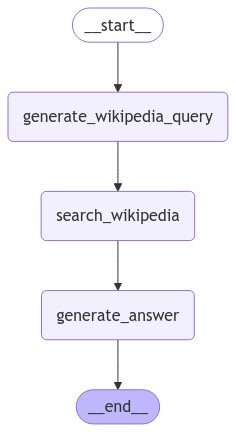

In [38]:
from IPython.display import Image, display

try:
    display(
        Image(Algorithm_app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

# 결과물

In [39]:
test_input = "I don't really understand what the Selection Sort algorithm is. Please explain it to me in detail and in an easy way."

In [40]:
output = Algorithm_app.invoke(AlgorithmState(user_input=test_input))

In [41]:
from IPython.display import display, Markdown
display(Markdown(output["output"]))

Selection Sort is a simple sorting algorithm used in computer science. It is an in-place comparison sort, meaning it reorders the elements by comparing them directly. Here's how it works:

1. **Dividing the List**: The algorithm divides the input list into two parts:
   - A sorted sublist that starts empty and gradually grows from left to right.
   - An unsorted sublist that initially contains all the elements.

2. **Sorting Process**:
   - The algorithm repeatedly finds the smallest (or largest) element in the unsorted sublist.
   - It then swaps this element with the leftmost unsorted element, placing it in sorted order.
   - The boundaries of the sorted and unsorted sublists are adjusted accordingly.

3. **Example**:
   Let's use an example to illustrate Selection Sort:
   - Given the list: 64 25 12 22 11
   - The algorithm finds the smallest element (11) and swaps it with the first element:
     11 25 12 22 64
   - It continues this process for the remaining elements, resulting in a sorted list:
     11 12 22 25 64

4. **Efficiency**:
   - Selection Sort has a time complexity of O(n^2), meaning it becomes inefficient for large lists.
   - It performs worse than some other sorting algorithms like Insertion Sort.
   - However, Selection Sort is easy to understand and can be advantageous in situations where auxiliary memory is limited.

In summary, Selection Sort is a straightforward algorithm that repeatedly selects the smallest (or largest) element from the unsorted part of the list and places it in its correct position in the sorted part. While it may not be the most efficient for large datasets, its simplicity and ability to work with limited memory make it a useful sorting technique in certain scenarios.